In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

/home/ic-lab/miniconda3/envs/torch_v1.9_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
task_datasets = []

# Task 1
task1_data = np.load('./cwru1_X_train.npy')
task1_labels = np.load('./cwru2_y_train.npy')

# Task 2
task2_data = np.load('./cwru2_X_train.npy')
task2_labels = np.load('./cwru2_y_train.npy')

# Task 3
task3_data = np.load('./cwru3_X_train.npy')
task3_labels = np.load('./cwru3_y_train.npy')

# Task 4
task4_data = np.load('./cwru4_X_train.npy')
task4_labels = np.load('./cwru4_y_train.npy')

In [3]:
# Convert the data to PyTorch tensors
# Task 1
task1_data = torch.from_numpy(task1_data)
task1_labels = torch.from_numpy(task1_labels)

# Task 2
task2_data = torch.from_numpy(task2_data)
task2_labels = torch.from_numpy(task2_labels)

# Task 3
task3_data = torch.from_numpy(task3_data)
task3_labels = torch.from_numpy(task3_labels)

# Task 4
task4_data = torch.from_numpy(task4_data)
task4_labels = torch.from_numpy(task4_labels)

In [4]:
# data transpose
task1_data = task1_data.transpose(1, 2)
task2_data = task2_data.transpose(1, 2)
task3_data = task3_data.transpose(1, 2)
task4_data = task4_data.transpose(1, 2)

In [5]:
# dataset for task 1~4
dataset1 = torch.utils.data.TensorDataset(task1_data, task1_labels)
dataset2 = torch.utils.data.TensorDataset(task2_data, task2_labels)
dataset3 = torch.utils.data.TensorDataset(task3_data, task3_labels)
dataset4 = torch.utils.data.TensorDataset(task4_data, task4_labels)

In [6]:
# 划分训练集和测试集
train_size = int(0.8 * len(dataset1))
test_size = len(dataset1) - train_size

train_dataset1, test_dataset1 = random_split(dataset1, [train_size, test_size])
train_dataset2, test_dataset2 = random_split(dataset2, [train_size, test_size])
train_dataset3, test_dataset3 = random_split(dataset3, [train_size, test_size])
train_dataset4, test_dataset4 = random_split(dataset4, [train_size, test_size])

In [7]:
task_datasets.append((train_dataset1, test_dataset1))
task_datasets.append((train_dataset2, test_dataset2))
task_datasets.append((train_dataset3, test_dataset3))
task_datasets.append((train_dataset4, test_dataset4))

## When task_id == 4, testing on other task' testset.

In [11]:
# 定义WDCNN模型
class WDCNN(nn.Module):
    def __init__(self, num_classes):
        super(WDCNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 256, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


# 定义EWC训练函数
def train_ewc(model, fisher_matrix, task_datasets, num_epochs=5, lr=0.001, batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    task_accuracies = []
    task_losses = []

    for task_idx, (train_dataset, test_dataset) in enumerate(task_datasets):
        print(train_dataset)
        print(f"Training Task {task_idx+1}")
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # 计算当前任务的Fisher信息矩阵
        fisher_matrix_task = []
        for param in model.parameters():
            fisher_matrix_task.append(torch.zeros_like(param.data))

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs = inputs.to(device, dtype=torch.double)
                labels = labels.to(device, dtype=torch.long)

                # inputs = inputs.to(device)  # 移动到设备上
                # labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()

                for i, param in enumerate(model.parameters()):
                    fisher_matrix_task[i] += param.grad.data ** 2

                optimizer.step()

        # 更新Fisher信息矩阵
        if task_idx == 0:
            fisher_matrix = fisher_matrix_task
        else:
            for i in range(len(fisher_matrix)):
                fisher_matrix[i] += fisher_matrix_task[i]

        if task_idx == 3:
            accuracies = []
            losses = []
            for j in range(4):
                test_loader = torch.utils.data.DataLoader(task_datasets[j][1], batch_size=32, shuffle=False)
                total = 0.0
                correct = 0.0
                task_loss = 0.0
                for inputs, labels in test_loader:
                    inputs = inputs.to(device, dtype=torch.double)
                    labels = labels.to(device, dtype=torch.long)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    task_loss += loss.item()
                    
                accuracy = 100 * correct / total
                loss_avg = task_loss / len(test_loader)
                accuracies.append(accuracy)
                losses.append(loss_avg)
            
                print(f"Accuracy on all Task {j+1}: {accuracy:.2f}%")
                print(f"Loss on all Task {j+1}: {loss_avg:.4f}")
            
            
        else:
            # 在当前任务上进行测试
            model.eval()
            correct = 0
            total = 0
            task_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs = inputs.to(device, dtype=torch.double)
                    labels = labels.to(device, dtype=torch.long)

                    # inputs = inputs.to(device)  # 移动到设备上
                    # labels = labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    task_loss += loss.item()

            accuracy = 100 * correct / total
            loss_avg = task_loss / len(test_loader)
            task_accuracies.append(accuracy)
            task_losses.append(loss_avg)

            print(f"Task {task_idx+1} Accuracy: {accuracy:.2f}%")
            print(f"Task {task_idx+1} Loss: {loss_avg:.4f}")

    return task_accuracies, task_losses

In [12]:
num_tasks = 4
num_classes = 10
samples = 14000

# 创建WDCNN模型实例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WDCNN(num_classes).to(device)

# 计算初始Fisher信息矩阵
fisher_matrix = []
for param in model.parameters():
    fisher_matrix.append(torch.zeros_like(param.data))

# 使用EWC训练模型
model.double()
task_accuracies, task_losses = train_ewc(model, fisher_matrix, task_datasets, num_epochs=10)

Training Task 1
Task 1 Accuracy: 99.75%
Task 1 Loss: 0.0074
Training Task 2
Task 2 Accuracy: 99.82%
Task 2 Loss: 0.0036
Training Task 3
Task 3 Accuracy: 99.96%
Task 3 Loss: 0.0006
Training Task 4
Accuracy on all Task 1: 78.25%
Loss on all Task 1: 2.0545
Accuracy on all Task 2: 89.29%
Loss on all Task 2: 0.7993
Accuracy on all Task 3: 93.64%
Loss on all Task 3: 0.3574
Accuracy on all Task 4: 100.00%
Loss on all Task 4: 0.0001


## Useing EWC training, accuracy of every tasks.

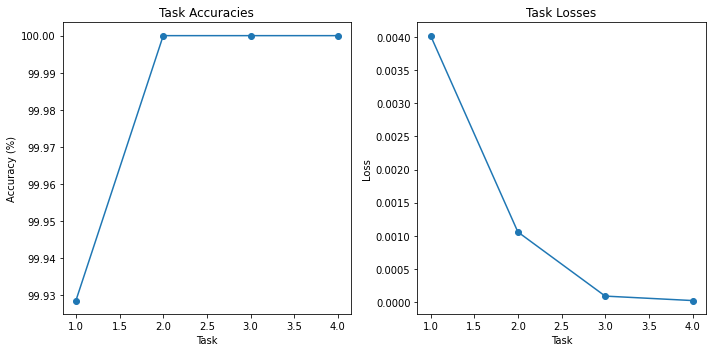

In [15]:
# 可视化结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_tasks + 1), task_accuracies, marker='o')
plt.xlabel('Task')
plt.ylabel('Accuracy (%)')
plt.title('Task Accuracies')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_tasks + 1), task_losses, marker='o')
plt.xlabel('Task')
plt.ylabel('Loss')
plt.title('Task Losses')

plt.tight_layout()
plt.show()


In [13]:
# 定义WDCNN模型
class WDCNN(nn.Module):
    def __init__(self, num_classes):
        super(WDCNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 256, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


# 定义EWC训练函数
def train_ewc(model, fisher_matrix, task_datasets, num_epochs=5, lr=0.001, batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    task_accuracies = []
    task_losses = []

    for task_idx, (train_dataset, test_dataset) in enumerate(task_datasets):
        print(train_dataset)
        print(f"Training Task {task_idx+1}")
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # 计算当前任务的Fisher信息矩阵
        fisher_matrix_task = []
        for param in model.parameters():
            fisher_matrix_task.append(torch.zeros_like(param.data))

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs = inputs.to(device, dtype=torch.double)
                labels = labels.to(device, dtype=torch.long)

                # inputs = inputs.to(device)  # 移动到设备上
                # labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()

                for i, param in enumerate(model.parameters()):
                    fisher_matrix_task[i] += param.grad.data ** 2

                optimizer.step()

        # 更新Fisher信息矩阵
        if task_idx == 0:
            fisher_matrix = fisher_matrix_task
        else:
            for i in range(len(fisher_matrix)):
                fisher_matrix[i] += fisher_matrix_task[i]

        model.eval()
        accuracies = []
        losses = []
        for j in range(4):
            test_loader = torch.utils.data.DataLoader(task_datasets[j][1], batch_size=32, shuffle=False)
            total = 0.0
            correct = 0.0
            task_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs = inputs.to(device, dtype=torch.double)
                    labels = labels.to(device, dtype=torch.long)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    task_loss += loss.item()

                accuracy = 100 * correct / total
                loss_avg = task_loss / len(test_loader)
                accuracies.append(accuracy)
                losses.append(loss_avg)

                print(f"Accuracy on all Task {j+1}: {accuracy:.2f}%")
                print(f"Loss on all Task {j+1}: {loss_avg:.4f}")
            
            task_accuracies.append(accuracies)
            task_losses.append(losses)

    return task_accuracies, task_losses

In [14]:
num_tasks = 4
num_classes = 10
samples = 14000

# 创建WDCNN模型实例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WDCNN(num_classes).to(device)

# 计算初始Fisher信息矩阵
fisher_matrix = []
for param in model.parameters():
    fisher_matrix.append(torch.zeros_like(param.data))

# 使用EWC训练模型
model.double()
task_accuracies, task_losses = train_ewc(model, fisher_matrix, task_datasets, num_epochs=5)

Training Task 1
Accuracy on all Task 1: 99.46%
Loss on all Task 1: 0.0162
Accuracy on all Task 2: 62.32%
Loss on all Task 2: 3.0604
Accuracy on all Task 3: 56.82%
Loss on all Task 3: 3.9319
Accuracy on all Task 4: 50.79%
Loss on all Task 4: 3.0742
Training Task 2
Accuracy on all Task 1: 84.11%
Loss on all Task 1: 0.3763
Accuracy on all Task 2: 96.68%
Loss on all Task 2: 0.0832
Accuracy on all Task 3: 93.89%
Loss on all Task 3: 0.1335
Accuracy on all Task 4: 86.46%
Loss on all Task 4: 1.0254
Training Task 3
Accuracy on all Task 1: 83.64%
Loss on all Task 1: 1.0350
Accuracy on all Task 2: 98.39%
Loss on all Task 2: 0.1637
Accuracy on all Task 3: 99.93%
Loss on all Task 3: 0.0014
Accuracy on all Task 4: 90.54%
Loss on all Task 4: 0.8667
Training Task 4
Accuracy on all Task 1: 85.54%
Loss on all Task 1: 0.9700
Accuracy on all Task 2: 93.07%
Loss on all Task 2: 0.3783
Accuracy on all Task 3: 97.96%
Loss on all Task 3: 0.0482
Accuracy on all Task 4: 100.00%
Loss on all Task 4: 0.0004


In [ ]:
for task_train_dataset, task_test_dataset in [(task1_train_dataset, task1_test_dataset),
                                                 (task2_train_dataset, task2_test_dataset),
                                                 (task3_train_dataset, task3_test_dataset),
                                                 (task4_train_dataset, task4_test_dataset)]: